# Exploring E-Juice tweets
Here we attempt to understand the topics used to describe/discuss E-Juice products on Twitter. The tweets for this analysis were mined from **1st Jan 2018, 00:00 hrs** to **31st Dec 2018, 23:59 hrs**. The keywords used to filter the tweets are:

- `e-juice`
- `e-liquids`
- `e juice`
- `e liquids`

There were a total of **85803** tweets and re-tweets from **21598** users. On discarding re-tweets, **25842** tweets from **6682** users were left. After filtering out tweets from bots, and non-english tweets, we are left with **15927** tweets from **4590** unique users.

In [1]:
import itertools as it
import nltk
import numpy as np
import pandas as pd
import pickle
import plotly
import os
import string

from collections import Counter
from types import SimpleNamespace
from wordcloud import WordCloud

TWEET_FILE = '../data/Tweets/cleanTweets.pickle'
FASTTEXT_MODEL_FILE = '../resources/wiki.en'

#nlp = spacy.load('en')
stopwords = set(nltk.corpus.stopwords.words('english'))
punctuation = set(string.punctuation)

## Loading the data
The tweets are loaded from the disk and we find frequent onegrams and bigrams in the tweets. In order to create an n-gram, we perform a number of transformation:

- **Basic normalization:** Lower case all tweets, remove extra spaces, remove punctuation between words, and remove special characters such as brackets, etc.
- **Stop word removal:** Words such as 'a', 'the', etc. are heavily represented in the English language. Such words add to the syntax, but rarely add to the meaning of the sentence. To make analysis easier, we ignore these words.
- **Normalizing twitter user mentions:** In twitter @person_name is used to tag people, and pages in your post. The name of each person tagged has little importance to us, but we would like to maintain statistics on the number of people tagged. Therefore, all @xyz occurrences in the tweets have been replaced by @person - a common token for all people.
- **Lemmatization:** Words such as 'walked', and 'walk' should be conflated in our analysis, so we would like to break down words into their basic form by removing inflections, and variants.
- **Non-printable character removal:** Unicode characters in tweets are often used for emoticons, or as symbols from other languages. Since we are dealing with tweets in English, we can remove these symbols without much loss in the meaning of the sentence.
- **Remove hashtags, and urls in the tweet**: Hashtags are useful for filtering out tweets which relate to a group (like e-juices), but don't add much value when trying to divide the group into topics. URLs embedded in the tweet are usually links to images (which on twitter are shown as embedded images), and external links to other websites. Since not much can be said about a website just from its URL, we can discard it.

In [2]:
def load_tweets(tweet_file):
    with open(tweet_file, 'rb') as file_handle:
        return pickle.load(file_handle)

def gen_ngrams(tweets):
    onegrams, bigrams = {}, {}
    for text in tweets.NormalizedText:
        seen = set()
        prev = None
        for word in text:
            if word in punctuation or word.isdigit() or word in stopwords or word[0] == '#':
                continue
            if word not in onegrams:
                onegrams[word] = 1
            elif word not in seen:
                onegrams[word] += 1
            seen.add(word)
            if prev is not None:
                bigram = '-'.join([prev, word])
                if bigram not in bigrams:
                    bigrams[bigram] = 1
                elif bigram not in seen:
                    bigrams[bigram] += 1
                seen.add(bigram)
            prev = word
    onegrams = pd.DataFrame.from_dict(onegrams, orient='index', columns=['Freq'])
    onegrams.sort_values(by=['Freq'], ascending=False, inplace=True)
    bigrams = pd.DataFrame.from_dict(bigrams, orient='index', columns=['Freq'])
    bigrams.sort_values(by=['Freq'], ascending=False, inplace=True)
    return SimpleNamespace(tweets=tweets, onegrams=onegrams, bigrams=bigrams)

In [3]:
dfs = gen_ngrams(load_tweets(TWEET_FILE))

In [4]:
import matplotlib.pyplot as plt

def create_wordCloud(freqDict, w=800, h=600):
    wc = WordCloud(width=w, height=h).generate_from_frequencies(freqDict)
    plt.figure(figsize=(30,30))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

After creating the n-grams, we can create word clouds to visual the relative frequency of different n-grams within the corpus. The larger the n-gram in the image, the more frequently it appeared in the corpus.

Frequent n-grams can then be used as seed points to identify commonly occuring topics.

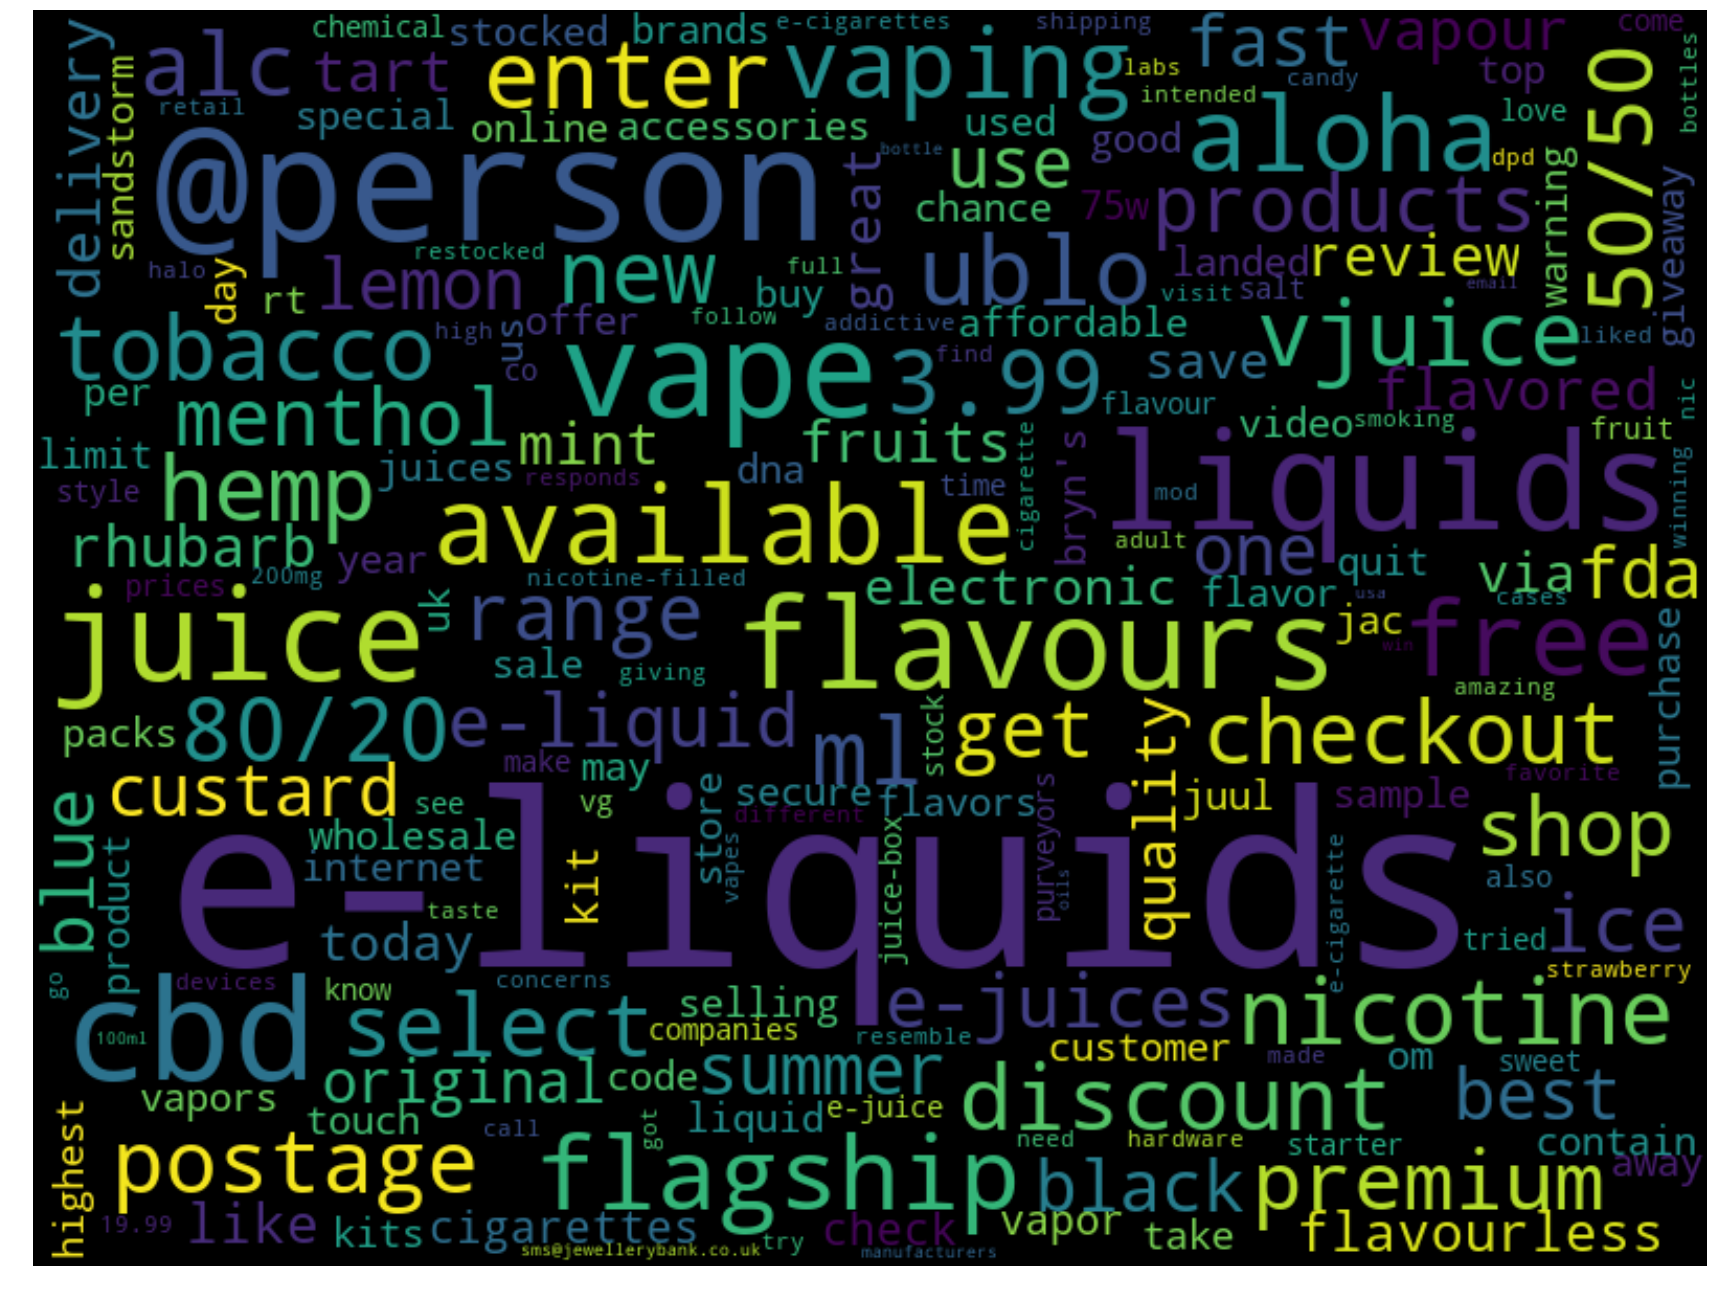

In [5]:
create_wordCloud(dfs.onegrams.to_dict()['Freq'])

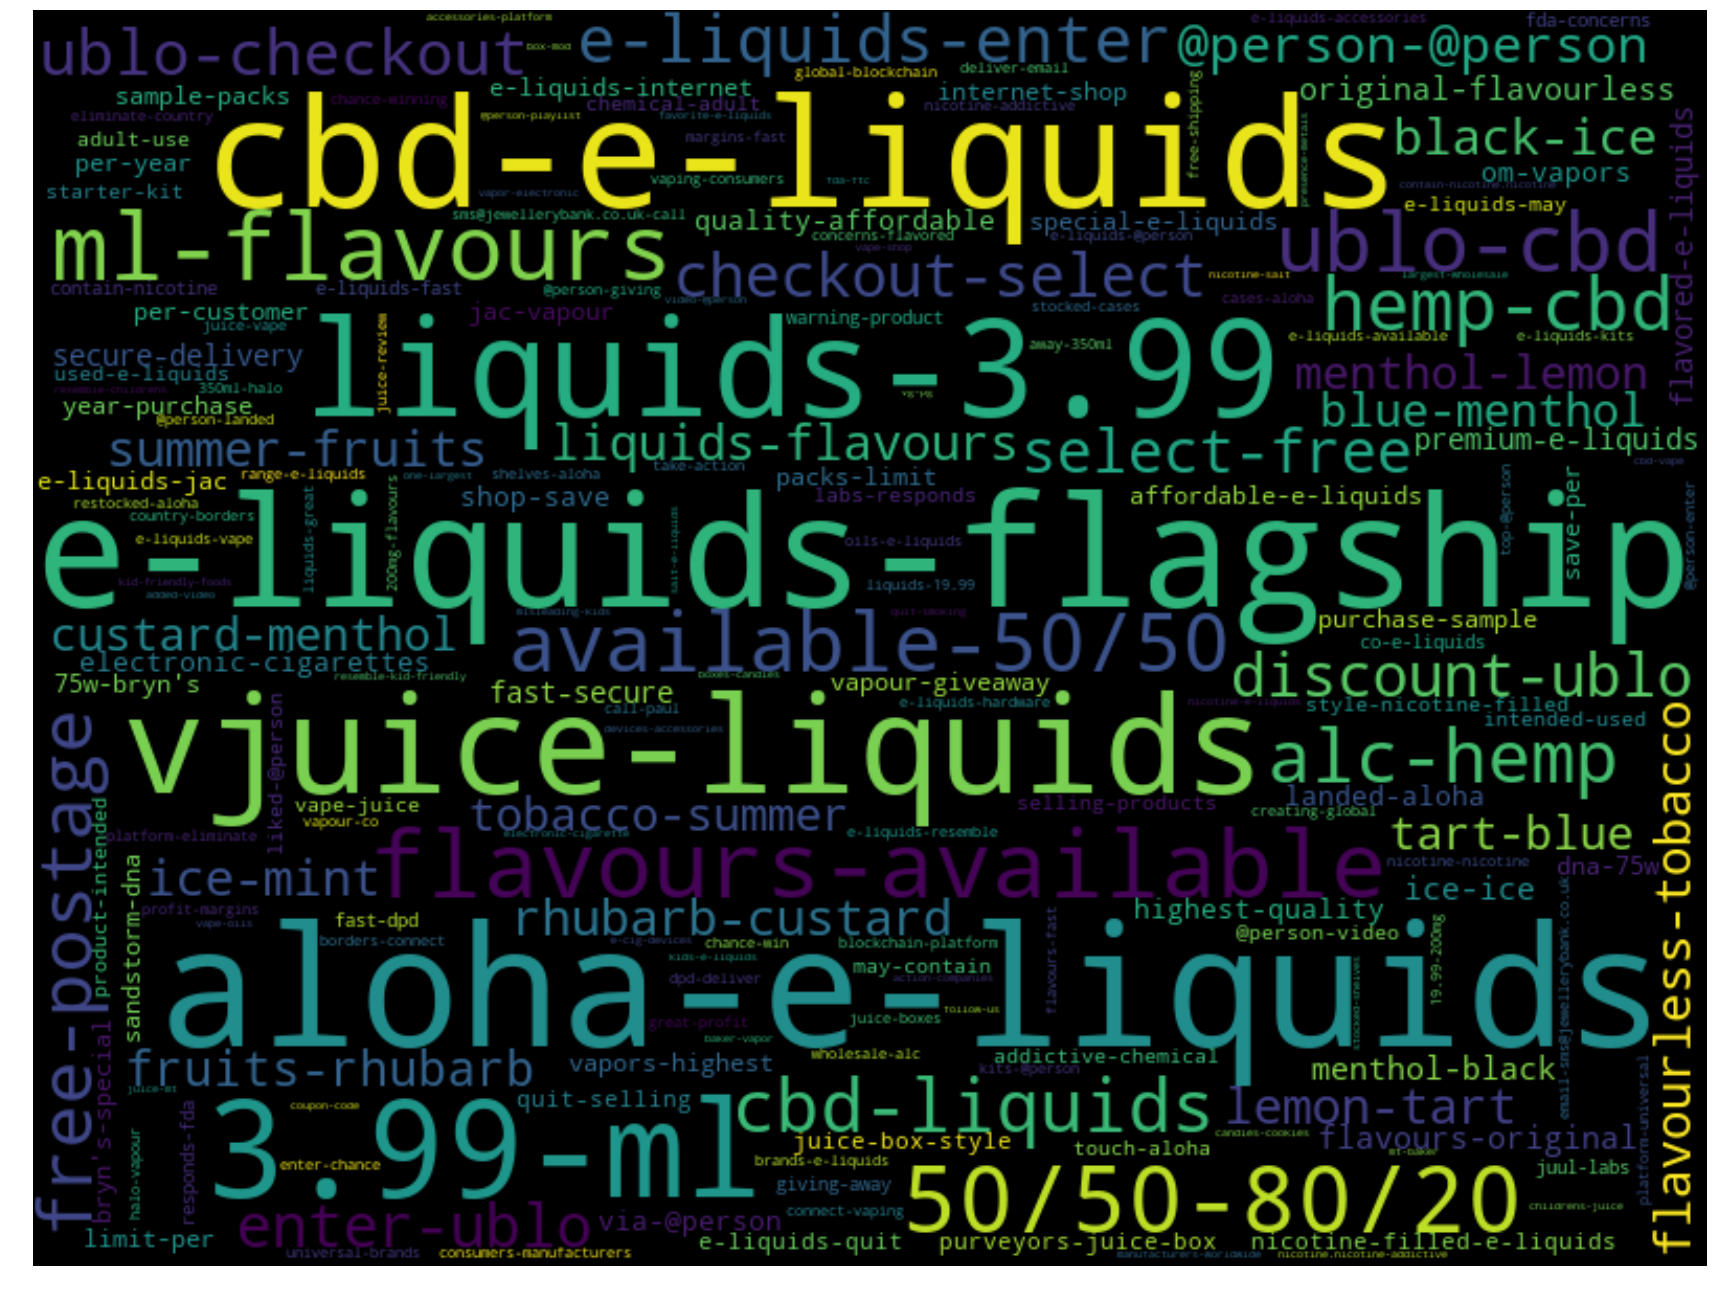

In [6]:
create_wordCloud(dfs.bigrams.to_dict()['Freq'])

## Classify Tweets into Topics

From the wordclouds we can identify a few commonly occuring topics. Eg: promotional content, flavours, etc. Using the n-grams in the wordclouds as seeds, we can find other identifiers for a topic be looking for n-grams similar to or co-occuring with the seed.

In order to classify a tweet into a topic we search for a list of n-grams that represent the topic within each tweets. If at least one n-gram matches, the tweet is considered a member of the topic.

In [5]:
def classify(tweets, ngram_pattern):
    results = set()
    for tweet in tweets.itertuples():
        for pattern in ngram_pattern:
            include = False
            if type(pattern) == str:
                include = pattern in tweet.NormalizedText
            elif type(pattern) == list:
                start = 0
                for word in pattern:
                    for i in range(start, len(tweet.NormalizedText)):
                        if word == tweet.NormalizedText[i]:
                            start = i
                            break
                    else:
                        break
                else:
                    include = True
            elif type(pattern) == tuple:
                if any(ngram == pattern for ngram in nltk.ngrams(tweet.NormalizedText, len(pattern))):
                    include = True
            if include:
                results.add(tweet.Id)
                break
    num_selected = len(results)
    print(f'Num of tweets in topic: {num_selected} (%.2f%%)' % (num_selected / tweets.shape[0] * 100))
    return results

### Promotional
This topic includes mentions of giveaways, discounds, and other offers for the purchase of E-Juices.

In [6]:
promotional = classify(dfs.tweets, [
    'checkout',
    'discount',
    'shop',
    'affordable',
    'purchase',
    'giveaway',
    'wholesale',
    ('premium', 'e-liquids'),
    ('e-liquids', 'flagship'),
    ('free', 'postage'),
    ('used', 'e-liquids'),
    ('starter', 'kit'),
    ('buy', 'liquids'),
    ('premium', 'e-liquid'),
    ('starter', 'kits'),
    ('buy', 'liquid'),
    ('free', 'shipping'),
    ('deals', 'promotions')
])

Num of tweets in topic: 4675 (29.35%)


### Flavors
This topic contains tweets that mention the different flavors the E-Juice is available in. This could be done in either promotional tweets, or by people expressing their likes and dislikes among E-Juice products.

In [7]:
flavors = classify(dfs.tweets, [
    'flavours',
    'flavors',
    'flavored',
    'mango',
    'blueberry',
    'raspberry',
    'banana',
    'melon',
    'vanilla',
    'apple',
    'candy',
    'fruit',
    'fruity',
    ('original', 'flavourless'),
    ('flavourless', 'tobacco'),
    ('lemon', 'tart'),
    ('black', 'ice'),
    ('rhubarb', 'custard'),
    ('ice', 'mint'),
    ('summer', 'fruits'),
    ('fruits', 'rhubarb'),
    ('custard', 'menthol'),
    ('menthol', 'lemon'),
    ('tart', 'blue'),
    ('blue', 'menthol'),
    ('menthol', 'black')
])

Num of tweets in topic: 3857 (24.22%)


### Cannabis
A lot of E-Juices mention the presence of CBD.

In [8]:
cannabis = classify(dfs.tweets, [
    'cbd',
    'weed',
    'hemp',
    'marijuana'
])

Num of tweets in topic: 2680 (16.83%)


### Juice Composition
This topic contains tweets that discuss any of the following properties related to juice composition:
- `vg/pg`, `50/50`, `80/20`: The proportion of vegetable glycerin vs propylene glycerin
- `ml`: The and the quantity of the juice (in milli-liters) discussed (usually for buying/sale).
- `mg`: The quantity of nicotine salts in an E-Juice (in milli-grams).

In [9]:
composition = classify(dfs.tweets, [
    'vg',
    'pg',
    'ml',
    'mg',
    '50/50',
    '80/20',
    ('nicotine', 'salts'),
    ('nicotine', 'salt')
]);

def add_composition_tweets(tweets, selected):
    for tweet in tweets.itertuples():
        if 'mg ' in tweet.Text or 'ml ' in tweet.Text:
            selected.add(tweet.Id)
    num = len(selected)
    print(f'Num of tweets in topic: {num} (%0.2f%%)' % (num / tweets.shape[0] * 100))
    return selected

composition = add_composition_tweets(dfs.tweets, composition)

Num of tweets in topic: 1575 (9.89%)
Num of tweets in topic: 2806 (17.62%)


### Nicotine Health Risks
This topic captures tweets discussing nicotine safety. This topic excludes tweets that are warning labels on promotional tweets.

In order to find tweets in this topic, we first find all the tweets with the keyword `nicotine`, and then we remove tweets which belong to other topics. To identify such tweets, we use a set of patterns that indicate participation in topics not related to a conversation about the safety. The following patterns were used:

- `warning ...<any_other_words>... addictive`: This pattern matches disclaimers on promotional material.
- `addictive ...<any_other_words>... chemicals`: Same as above. Matches a variation of the same disclaimer.
- `nicotine salts`: This bigram is usually used only in promotional content.
- `wholesale`: Indicate promotional content.
- `buy`: Also indicate promotional content.

In [10]:
nicotine_safety = dfs.tweets[dfs.tweets.Id.isin(classify(dfs.tweets, [
    'nicotine',
    'kid-friendly',
    ('misleading', 'kids'),
    'children'
]))]

# Remove tweets which contain the following n-grams
nicotine_safety = nicotine_safety[~nicotine_safety.Id.isin(classify(nicotine_safety, [['warning', 'addictive'], ['addictive', 'chemical'], ('nicotine', 'salts'), 'wholesale', 'buy']))]
print(f'Final number of tweets in topic: {nicotine_safety.shape[0]} (%.2f%%)' % (nicotine_safety.shape[0] / dfs.tweets.shape[0] * 100))
nicotine_safety = set(nicotine_safety.Id)

Num of tweets in topic: 1256 (7.89%)
Num of tweets in topic: 238 (18.95%)
Final number of tweets in topic: 1018 (6.39%)


### Person Tagging
Social posts where people were tagged while discussing E-Juice products.

In [11]:
person_tagging = classify(dfs.tweets, ['@person'])

Num of tweets in topic: 3419 (21.47%)


### Quit Smoking
Mentions of the intention to use E-Juice products in order to quit smoking.

In [12]:
quit_smoking = classify(dfs.tweets, [('quit', 'smoking')])

Num of tweets in topic: 90 (0.57%)


## Confusion Matrix
Since our topics overlap with each other, it will be useful to see the percentage of overlap between each topic. A confusion matrix is an useful visualization tool for this purpose.

Each cell in the matrix represents the intersection of two topics. The value of the cell represents the percentage of the total corpus which belong to both topics. For example, in the table below, the cell at the intersection of the Flavors column, and Promotional row represents the tweets which are promotional AND talk about the flavors available. The table shows that `495` tweets i.e. `3.11%` of the total `15927` tweets belong to this intersection.

In [14]:
def conf_matrix(classifications, tweets):
    total_tweets_classified = set(it.chain(*classifications.values()))
    total_tweets = tweets.shape[0]
    result = []
    for key1 in classifications:
        intersections = [key1]
        for key2 in classifications:
            intersection = classifications[key1] & classifications[key2]
            intersections.append('%s, %0.2f%%' % (len(intersection), len(intersection) / total_tweets * 100))
            #print(f'{key1}-{key2}: {len(intersection)} ({len(intersection) / total_tweets * 100}%)')
        result.append(intersections)
    total_tweets_classified_len = len(total_tweets_classified)
    print(f'Total classified: {total_tweets_classified_len} ({total_tweets_classified_len / total_tweets * 100}%)')
    negatives = tweets[~tweets.Id.isin(total_tweets_classified)]
    return pd.DataFrame(result, columns=['vs', *classifications.keys()]).set_index('vs'), negatives

_, negatives = conf_matrix({
    'Promotional': promotional,
    'Flavors': flavors,
    'Person Tagging': person_tagging,
    'Juice Composition': composition,
    'Cannabis': cannabis,
    'Nicotine Health Risks': nicotine_safety,
    'Quit Smoking': quit_smoking
}, dfs.tweets)

_

Total classified: 11925 (74.87285741194198%)


Promotional       Flavors Person Tagging  \
vs                                                                 
Promotional            4675, 29.35%    495, 3.11%     752, 4.72%   
Flavors                  495, 3.11%  3857, 24.22%     567, 3.56%   
Person Tagging           752, 4.72%    567, 3.56%   3419, 21.47%   
Juice Composition        241, 1.51%   1515, 9.51%     500, 3.14%   
Cannabis                1089, 6.84%    768, 4.82%     180, 1.13%   
Nicotine Health Risks     44, 0.28%    166, 1.04%     302, 1.90%   
Quit Smoking              39, 0.24%     13, 0.08%      51, 0.32%   

                      Juice Composition      Cannabis Nicotine Health Risks  \
vs                                                                            
Promotional                  241, 1.51%   1089, 6.84%             44, 0.28%   
Flavors                     1515, 9.51%    768, 4.82%            166, 1.04%   
Person Tagging               500, 3.14%    180, 1.13%            302, 1.90%   
Juice Composition          2806, 17.62%    436, 2.74%            216, 1.36%   
Cannabis                     436, 2.74%  2680, 16.83%             27, 0.17%   
Nicotine Health Risks        216, 1.36%     27, 0.17%           1018, 6.39%   
Quit Smoking                   3, 0.02%      1, 0.01%              2, 0.01%   

                      Quit Smoking  
vs                                  
Promotional              39, 0.24%  
Flavors                  13, 0.08%  
Person Tagging           51, 0.32%  
Juice Composition         3, 0.02%  
Cannabis                  1, 0.01%  
Nicotine Health Risks     2, 0.01%  
Quit Smoking             90, 0.57%

### Remaining Tweets

We found that a large number of tweets in the negatives are copies of two sets of tweets:
- Promotional tweets that contain a warning label on nicotine products.
- A set of tweets that all link to the same news article citing action against the sale of 'Juice-Box' style e-liquids.

Since these sets of tweets are almost exact copies of each other we discard them from the negatives.

In [15]:
negatives = negatives[~negatives.Id.isin(classify(dfs.tweets, [['warning', 'addictive'], ['addictive', 'chemical'], ('purveyors', 'of', 'juice-box')]))]
print(negatives.shape[0])

Num of tweets in topic: 478 (3.00%)
3584


In [16]:
_ngrams = gen_ngrams(negatives)

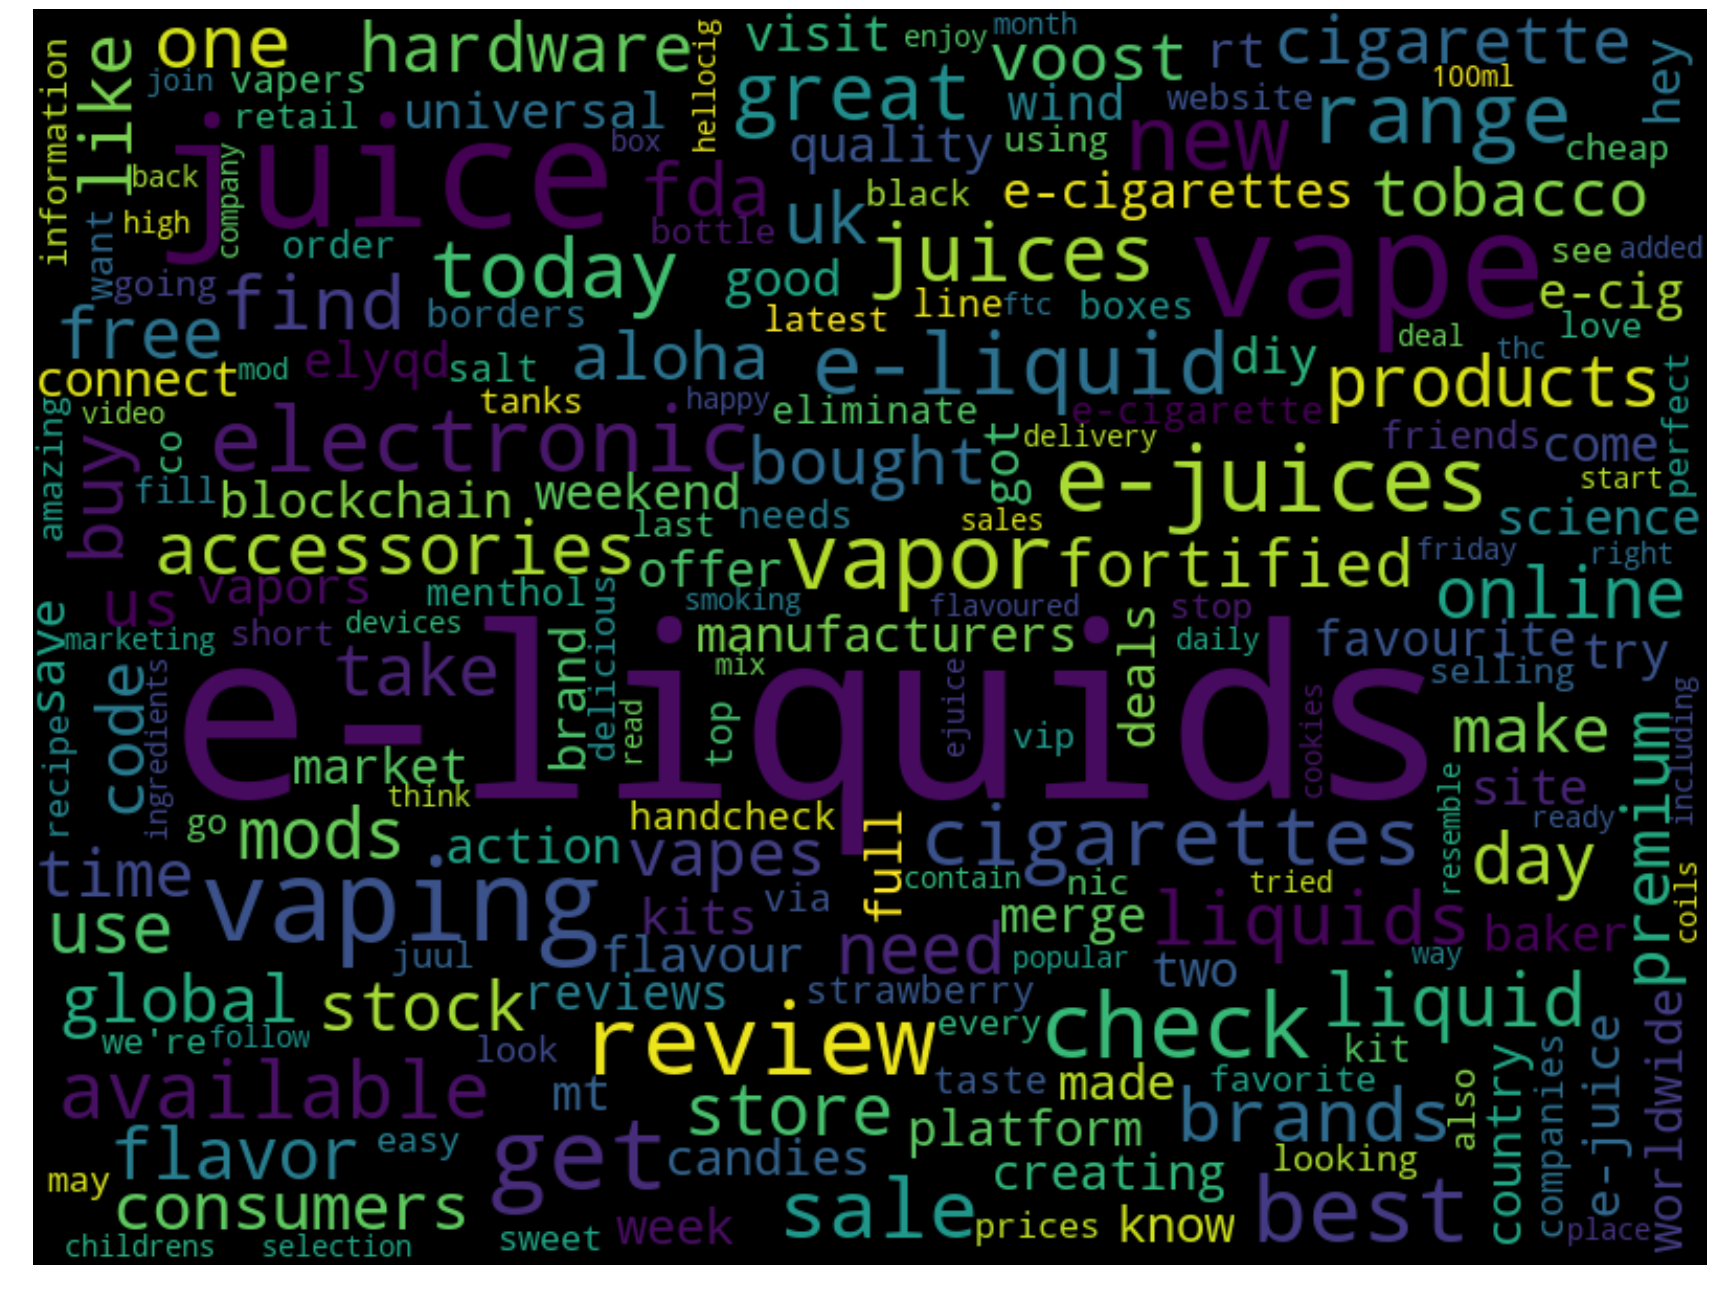

In [17]:
create_wordCloud(_ngrams.onegrams.to_dict()['Freq'])

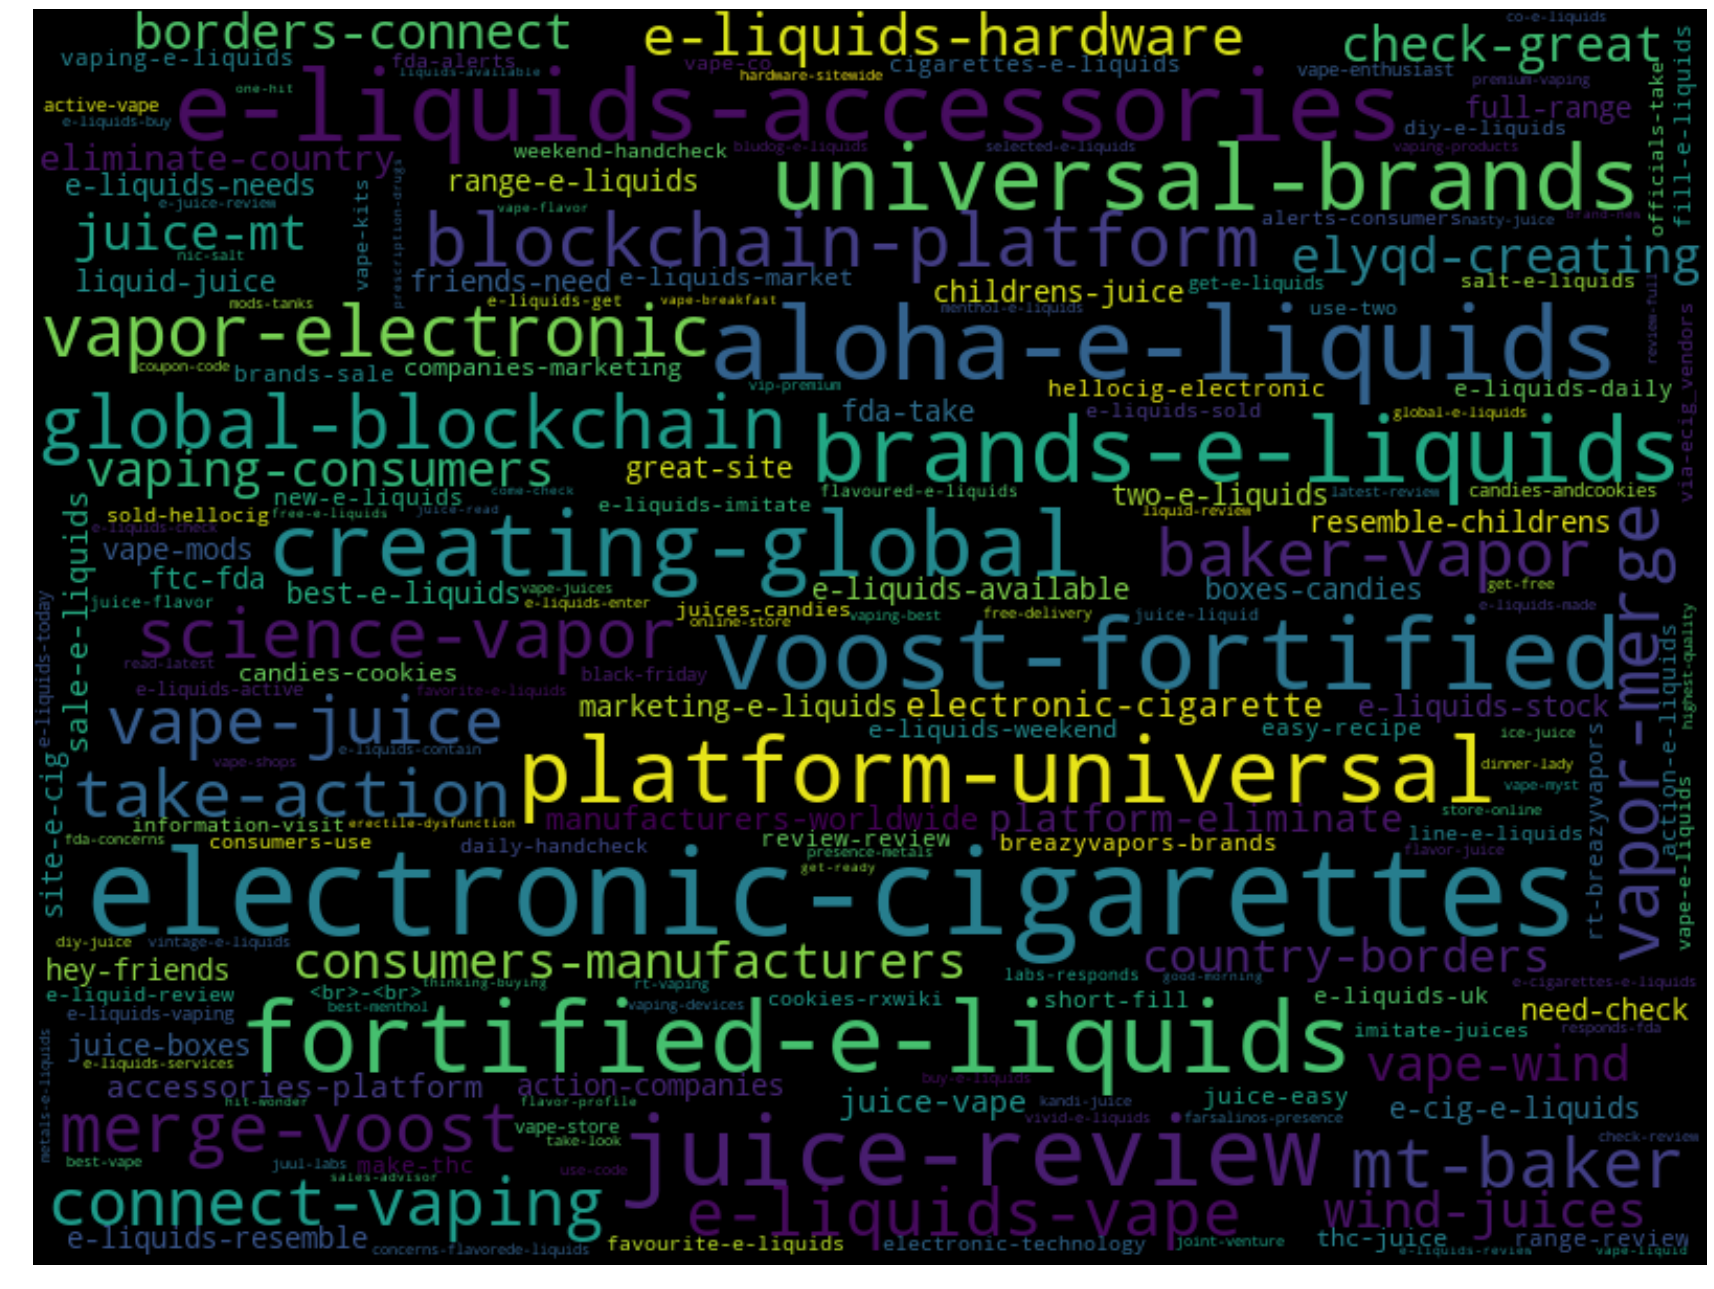

In [18]:
create_wordCloud(_ngrams.bigrams.to_dict()['Freq'])

### Rough Work (experimental code)

In [16]:
x = dfs.tweets[dfs.tweets.Id.isin(classify(dfs.tweets, [('nicotine', 'salts'), ('nicotine', 'salt')]))]
print(x.shape)
x.Text.head(50).tolist()

Num of tweets in topic: 147 (0.92%)
(147, 7)


['If you’re looking for a smooth, tasty yet punchy nicotine hit then the Ns20 range of e-liquids from #Element should be on your shopping list. Select any two flavours from the Element Ns20 Nicotine Salts range and save! 👉🏻https://t.co/wGMPctbLnv #vaping #nicsalts https://t.co/LP8WWC5NXp',
 'RT Vaping360 "Best Nicotine Salt E-Juices\nhttps://t.co/FHOhWiwgax"',
 'Purple Welch’s e juice by HiLIQ Vape Liquid - Wholesale Pure Nicotine , Best Nicotine Salt for sale, Cheap nicotine base, Buy E liquid nicotine wholesale https://t.co/hJ10llLwWw',
 'Fruit Freeze from poddrops has touch down at The Aloha E-Liquids Flagship |\nOur classic Fruit Cup flavor with a blast of ice and infused with nicotine salts |\nRetail:… https://t.co/0wxMMW4mRZ',
 'Best Nicotine Salt E-Juices 2018. This new alternative nicotine called nicotine salt is revitalizing the e-juice industry:\nhttps://t.co/M5iS1YFq1U @whycherrywhy \n4 of vaping360s top 7 nic salt brands available to NZ & Aussie vapers here: https://t.co/Qn

In [ ]:
gen_ngrams(x).bigrams

In [ ]:
gen_ngrams(x[x.Id.isin(classify(x, [('nicotine', 'salts')]))]).bigrams

In [19]:
x = dfs.tweets[dfs.tweets.Id.isin(composition)]

In [23]:
#classify(x, ['mg', 'ml'])
2672 - 1434

1238

In [24]:
dfs.tweets[dfs.tweets.Id.isin(classify(x, ['mg']))].Text.head(50).tolist()

Num of tweets in topic: 43 (1.61%)


['@femmeinjist @thetanmay Vaping e-liquids is the only way the consumer can control the amount of nicotine. 4 yrs. ago there was 24 mg. nicotine in my juice; today there is 0. I continue to vape because i enjoy it. My life, My choice.',
 '@RKHTV Hey Ryan it seems like you and I have the same taste n e-liquids. My question is where can I get good juice that is 8 or 12 mg nicotine strength? Love your videos by the way. I love Pink and I wish I could get it in 12 mg strength.',
 "@BRAVEmediaMO @FDATobacco BTW... 70% or more chose to #vape 0 mg e-liquids.\r\rThere's more nicotine in the potatoes they eat.",
 '@RKHTV I have a question for you. If you mix two e-juices together and they are both 3 mg nic level. Will the combination of the two make it 6 mg nic level?',
 '@LoveCBDOil Have you reduced the mg of your capsules? And the e-liquids are still out of stock?',
 'Read my Aug 14 Newsletter featuring “15% OFF Hemp Bombs CBD E-Liquids (2,000mg Cannabidiol) - Coupon Codes for…” https://t.co/